# Individual Analysis for the M&ouml;ssbauer experiment

## Results-only analysis template

**This template walks through the analysis of the results starting from the peak positions and widths of the raw MCA spectrum files, usually obtained with the LabVIEW program that reads the data from the Norland MCA, along with associated velocity transducer measurements for each sample.  If you wish to carry out a full fit of the multi-peak spectrum plus background, you should use the *Mossbauer Full Analysis* template.**

Use this template to carry out analysis of the spectrum results fro the M&ouml;ssbauer experiment.  You will need to have a spreadsheet file containing the peak positions and number for each spectrum.  You will also need to know the peak-to-peak amplitude of the velocity transducer output for each spectrum.

For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will use the [Uncertainties](https://pythonhosted.org/uncertainties/) package in this notebook.

In [10]:
import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
import scipy.constants as const
import pandas as pd
%matplotlib inline

### GLOBAL VARS
c=2.998E11   # speed of light in mm/s

### Tasks for this analysis

For each spectrum:

1. Use the peak-to-peak amplitude from the velocity transducer and to create a calibration function (a line).  You will need the function generator period and MCS dwell time.  The function should return a velocity in mm/s given a channel number.  Negative velocities should indicate negative energy shifts, and positive velocities should indicate positive energy shifts.

2. Apply your calibration function to the peak-position data sets for all spectral peaks. Record these results in tables, one table for each sample.  You want an ordered table of absorption peaks in units of mm/s.  Recommended: Make a DataFrame.

3. Then run the following calculations, depending on your samples
    * For **enriched iron &amp; natural iron**: Calculate (1) the isomer shift in mm/s, (2) the magnitide of the internal magnetic field in tesla and (3) the magnitude of the magnetic moment of the excited state in units of the nuclear magneton.  Compare values to expected results.

    * For **sodium nitroprusside**: Calculate (1) the isomer shift in mm/s, (2) the quadrupole splitting in mm/s. Then calculate the isomer shift compared to enriched Fe. Compare your value to expected results.

    * For **stainless steel**: Calculate (1) the isomer shift in mm/s of the single peak.  Then calculate the isomer shift realtive to enriched Fe.  Compare your value to the expected result.  Also calculate the peak width in velocity units to compare to the peak widths for enriched Fe and discuss whether you see evidence of a weak internal field (as opposed to zero internal field).
    
    * For **hematite**: Calculate all the folowing in mm/s: (1) the isomer shift relative to enriched Fe, (2) the splitting in the ground state, (3) the splitting in the excited state, (4) the quanrupole energy.  Then calculate the magnetic field magnitude in tesla. 


## Read in your results

Recommended: Make a CSV file for each sample.  The top row should have labels `'Pos'`, `'Pos_unc'`, `'Width'`, and `'Width_unc'`. Each row should be the data for a different peak number in the spectrum. Then create a DataFrame with uncertainty objects that combine the position and uncertainty values for each peak.

Use the **Pandas** `read_csv()` function to read the CSV file:

    Fe = pd.read_csv('enriched_Fe_peaks.csv')
    
The dataframe will be named `Fe`  with columns `Fe['Pos']`, `Fe['Pos_unc']`, `Fe['Width']`, `Fe['Width_unc']`. 

In [11]:
# Inverted Lorentzian peak equation: a*c^2/((x-b)^2+c^2)+d
# b = peak position (channel), c = peak width, a = peak height, d = baseline
Enriched_Fe = pd.read_csv('Enriched_Fe_Peaks.csv')
Fe2O3 = pd.read_csv('Hematite_Peaks.csv') # AKA Hematite
Natural_Fe = pd.read_csv('Natural_Fe_Peaks.csv') # 0.001 inches
SNP = pd.read_csv('SNP_Peaks.csv')
Stainless_Steel = pd.read_csv('Stainless_Steel_Peaks.csv')

# Print a table by just entering the name of the dataframe:
Enriched_Fe

# Creation of uncertainty objects


,Pos,Pos_unc,Width,Width_unc
0,143.083151,0.000411,9.356082,0.000589
1,294.024709,0.000429,9.393148,0.000615
2,446.305774,0.000442,4.910503,0.000629
3,560.178525,0.000469,5.179656,0.000667
4,712.988996,0.000403,9.021720,0.000577
5,866.987314,0.000439,10.150513,0.000631


## Calibrate the data sets

### Create the calibration function(s)

Think carefully about the motion of the source: where is it at the begining of the scan?  which direction is it moving? 

Think carefully about the dwell time and how long an MCS cycle takes.  (One cycle is a run through all channels.)  At which channel is the velocity zero?  Which channel would have the highest velocity forward and which would have the highest velocity in reverse.  Once you know this, you create a line that interpolates between these points. 

If you have not already converted channel numbers to mm/s values using the velocity transducer conversion factor and the peak-to-peak amplitude of the velocity transducer signal, do this below.

In [12]:
# Python "dictionary" to hold the peak-to-peak velocity transducer readings, in mV
# You supply values and write the function.  The numbers below are typical: replace them.

Vpp = {'Enriched_Fe':49.37, 'SNP':24.09, 'Fe2O3':73.86, 'Stainless_Steel':14.86,'Natural_Fe':48.64}

Vpp['Fe2O3']  # Should print the value for the labeled sample


73.86

#### Write the calibration function

Fill in the details below.

In [13]:
### CALIBRATION FUNCTIONS
###
### channel # to velocity
def velocity_cal(chan, Vpp, conv=0.295, dwell=5.0e-4, period=1.00):
    '''
    Velocity calibration function.  Converts channel number 'chan' to velocity with sign
    based on the measured peak-to-peak voltage from the velocity transducer 'Vpp' (in mV),
    the transducer conversion constant 'conv' (in (mm/s)/mV), the channel dwell time 
    'dwell' (in s), and the drive period 'period' (in s).  
    '''
    intercept = Vpp * conv/2
    slope = -Vpp * conv/999

    return(intercept + slope*(chan+0.5)) # slight correction to place velocity at middle of dwell time (1/2 channel)

### channel # to energy shift
def energy_cal(E_src, chan, Vpp, conv=0.295, dwell=5.0e-4, period=1.00):
    '''
    Energy calibration function.  Converts channel number 'chan' to energy shift between emitted photon
    and absorbed photon
    '''

    e_shift = E_src*(1/c)*(velocity_cal(chan, Vpp, conv=0.295, dwell=5.0e-4, period=1.00))
    
    return e_shift

# Test your function as follows

a_channel = 50
print("Velocity at channel {} = {:4g} mm/s".format(a_channel, velocity_cal(a_channel,Vpp=Vpp['Enriched_Fe'])))
print("Energy shift at channel {} = {:4g} eV".format(a_channel, energy_cal(14.4E3, a_channel,Vpp=Vpp['Enriched_Fe'])))


Velocity at channel 50 = 6.54585 mm/s
Energy shift at channel 50 = 3.1441e-07 eV


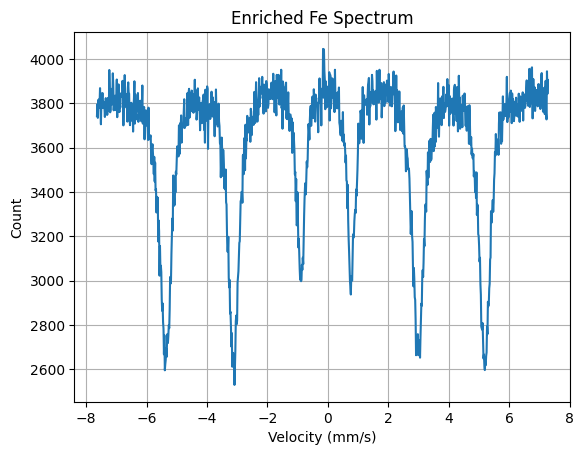

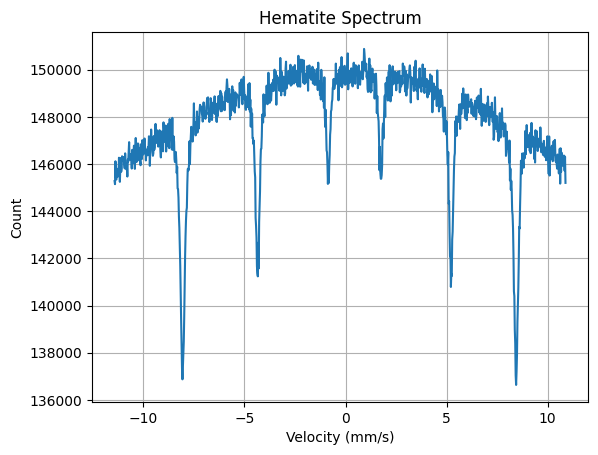

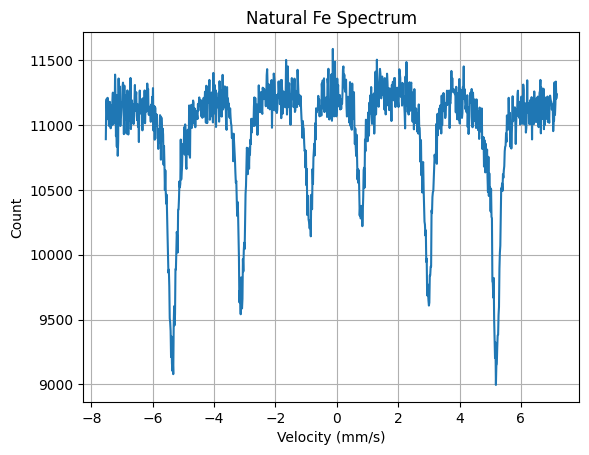

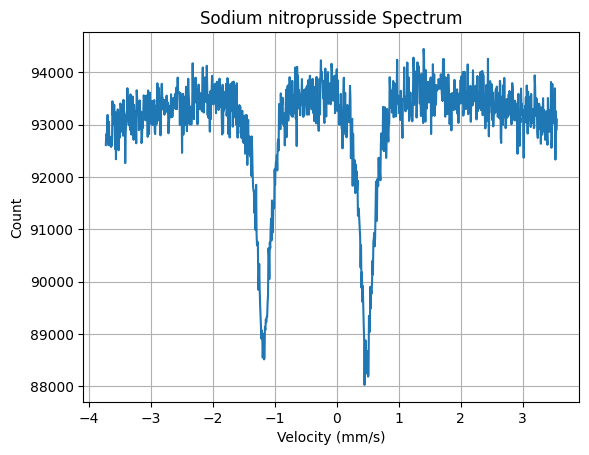

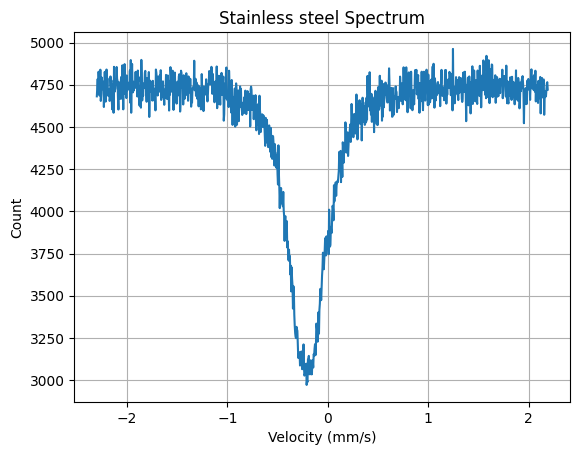

In [27]:
# Plots of full spectra after conversion to velocity instead of channels
Fe_Enriched_full = pd.read_csv('Full_Spectras/Enriched_57_Fe.csv',delimiter='\t')
Fe2O3_full = pd.read_csv('Full_Spectras/Hematite.csv',delimiter='\t')
Fe_Natural_full = pd.read_csv('Full_Spectras/Natural_Fe_0.001in.csv',delimiter='\t')
SNP_full = pd.read_csv('Full_Spectras/SNP.csv',delimiter='\t')
Stainless_Steel_full = pd.read_csv('Full_Spectras/Stainless_Steel.csv',delimiter='\t')

def plotter(material,select_Vpp,title):
    plt.plot(velocity_cal(material['Channel'],select_Vpp),material['Count'])
    plt.title(f'{title} Spectrum')
    plt.xlabel('Velocity (mm/s)')
    plt.ylabel('Count')
    plt.grid()
    plt.show()

plotter(Fe_Enriched_full,Vpp['Enriched_Fe'],'Enriched Fe')
plotter(Fe2O3_full,Vpp['Fe2O3'],'Hematite')
plotter(Fe_Natural_full,Vpp['Natural_Fe'],'Natural Fe')
plotter(SNP_full,Vpp['SNP'],'Sodium nitroprusside')
plotter(Stainless_Steel_full,Vpp['Stainless_Steel'],'Stainless steel')

### Create columns with uncertainty objects

The code in [Examples](https://github.com/Physics431/Examples) shows how to build "uncertainty" objects and how to calculate with them. 

Something like this should work:

    from uncertainties import unumpy
    
    Fe['u_pos'] = unumpy.uarray(Fe['Pos'],Fe['Pos_unc'])

This will add another column that combines the position and its uncertainty into a single array in its own column within the dataframe.  

### Convert the uncertainty object column from channels to velocities (with uncertainty)

If your calibration function only uses standard mathematical operators, you can feed this column through the calibration function to obtain the peak prositions and their uncertainty in units of mm/s. the **Uncertainties** package will propagate the uncertainty for you.  

In [15]:
from uncertainties import unumpy

Enriched_Fe['u_pos'] = unumpy.uarray(Enriched_Fe['Pos'],Enriched_Fe['Pos_unc'])
SNP['u_pos'] = unumpy.uarray(SNP['Pos'],SNP['Pos_unc'])
Fe2O3['u_pos'] = unumpy.uarray(Fe2O3['Pos'],Fe2O3['Pos_unc'])
Stainless_Steel['u_pos'] = unumpy.uarray(Stainless_Steel['Pos'],Stainless_Steel['Pos_unc'])
Natural_Fe['u_pos'] = unumpy.uarray(Natural_Fe['Pos'],Natural_Fe['Pos_unc'])

SNP

,Pos,Pos_unc,Width,Width_unc,u_pos
0,430.663291,0.000046,13.115068,0.000068,430.66329+/-0.00005
1,664.858545,0.000050,13.490171,0.000074,664.85855+/-0.00005


## Analyze each spectrum

Depending on your sample set, choose the appropriate set of tasks below.

### Enriched iron & natural iron

1. Start with isomer shift $\delta$. This is just the average of all peak locations. The number would be relative to the source Co-57/Rh

2. Next calculate the magnetic field $B$ and excited-state moment $\mu_e$ from the enriched-foil data.  

For the field, we first need the transitions that start from different ground states and end at the same excited states.  There are two pairs of these, one pair ends at -1/2: peaks 2 & 4, and the other ends at +1/2, peaks 1 and 3. The differences between these will give $\mu_gB$.  From this get $B$ with $\mu_g = +0.09062\mu_n$ where $\mu_n = 3.1525\times10^{-8}$ eV/T 

You will need to convert to energy with Doppler formula
$$\frac{\Delta E}{E} = \frac{v}{c}$$
where $E = 14.412497$ keV.

To get the excited state moment, you will need the excited state splitting. These pairs that start at the same ground state but end at different excited states: peaks 0-1, 1-2, 3-4, and 4-5.

3. From this calculate the excited state moment $\mu_e$, and compare to $-0.1549\mu_n$. 

4. Repeat the above for any other natural iron samples you may have. (Don't forget to apply the correct calibration constant for each one.)

In [31]:
peak_avg = np.average(Enriched_Fe['u_pos'])
E_src = 14413                    # eV
Vpp_EnrFe = Vpp['Enriched_Fe']   # mV
un=3.1525E-8                     # eV/T
ug=0.09062*un                    # eV/T

isoshift_Fe=energy_cal(E_src, peak_avg, Vpp_EnrFe)
isoshift_Fe_mms=velocity_cal(peak_avg, Vpp_EnrFe)
print("The isomer shift for enriched Fe: ", isoshift_Fe, "eV")
print("or: ", isoshift_Fe_mms, "mm/s")

print("Removing isomer shift, the energy shifts (delta_E_abs - delta_E_shift) due to magnetic splitting alone are:")
adjusted_peaks=energy_cal(E_src, Enriched_Fe['Pos'], Vpp_EnrFe) - isoshift_Fe

print("")
for i in range(6):
    print(adjusted_peaks[i], "eV")

delta_shift_24=adjusted_peaks[4]-adjusted_peaks[2]
print("\nPeaks 2 and 4 begin at the same ground level, and their difference is: ", delta_shift_24, "eV")

B_EnrFe = -delta_shift_24/(2*ug)
print("plugging in their quantum numbers and the known value ug, B is: ", B_EnrFe, "T")

delta_shift_45=adjusted_peaks[5]-adjusted_peaks[4]
ue=(delta_shift_45/B_EnrFe)*(3/2)
print("\nPeaks 4 and 5 end at the same excited state. We used this and our B value to calculate ue: ", ue, "eV/T")
print("We then took the ratio ue/un: ", ue/un, ". This very close to the expected value.")

The isomer shift for enriched Fe:  (-3.45398+/-0.00012)e-09 eV
or:  -0.0718451+/-0.0000026 mm/s
Removing isomer shift, the energy shifts (delta_E_abs - delta_E_shift) due to magnetic splitting alone are:

(2.5290826+/-0.0000012)e-07 eV
(1.4711665+/-0.0000012)e-07 eV
(4.038620+/-0.000012)e-08 eV
(-3.942470+/-0.000012)e-08 eV
(-1.4652619+/-0.0000012)e-07 eV
(-2.5446022+/-0.0000012)e-07 eV

Peaks 2 and 4 begin at the same ground level, and their difference is:  (-1.8654134782934704+/-0)e-07 eV
plugging in their quantum numbers and the known value ug, B is:  32.648705136462695+/-0 T

Peaks 4 and 5 end at the same excited state. We used this and our B value to calculate ue:  (-4.920631300349427+/-0)e-09 eV/T
We then took the ratio ue/un:  -0.15608663918634186+/-0 . This very close to the expected value.


In [32]:
# Natural Fe analysis
Nat_Fe_mean = np.average(Natural_Fe['u_pos'])

Nat_Fe_isoshift = energy_cal(E_src,Nat_Fe_mean,Vpp['Natural_Fe'])
NFe_vel = velocity_cal(Nat_Fe_mean,Vpp['Natural_Fe'])
print(f'Isomer shift: {Nat_Fe_isoshift} eV or {NFe_vel} mm/s')
NFe_adjusted_peaks = energy_cal(E_src, Natural_Fe['u_pos'],Vpp['Natural_Fe']) - Nat_Fe_isoshift
NFe_B_val = -(NFe_adjusted_peaks[4]-NFe_adjusted_peaks[2])/(2*ug)
print(f'B-field: {NFe_B_val} T')
NFe_ue = (NFe_adjusted_peaks[5]-NFe_adjusted_peaks[4])/NFe_B_val * (3/2)
print(f'Excited state magnetic moment: {NFe_ue} eV/T')

Isomer shift: (-3.02290+/-0.00006)e-09 eV or -0.0628784+/-0.0000012 mm/s
B-field: 32.87582+/-0.00004 T
Excited state magnetic moment: (-4.924309+/-0.000012)e-09 eV/T


### Sodium nitroprusside

Need isomer shift relative to Fe foil and quadrupole split, both in mm/s units.

Compare results to literature values of $-0.257$ mm/s for the isomer shift, relative to Fe and $1.7048$ mm/s for the quadrupole splitting.  

In [17]:
Vpp_SNP=Vpp['SNP']

isoshift_SNP_mms=velocity_cal(np.average(SNP['u_pos']), Vpp_SNP)
isoshift_SNPFe_mms=isoshift_SNP_mms - isoshift_Fe_mms

print("The isomer shift for SNP relative to the source was: ", isoshift_SNP_mms, "mm/s")
print("We calculated an isomer shift relative to Fe for SNP of: ", isoshift_SNPFe_mms, "mm/s")

eps_SNP=(SNP['u_pos'][1]-SNP['u_pos'][0])/2
print("\nWe calculated the quadrupole split, epsilon, by taking half the photon energy difference between the peaks:\nepsilon=", eps_SNP, "mm/s")

The isomer shift for SNP relative to the source was:  -0.34686877+/-0.00000024 mm/s
We calculated an isomer shift relative to Fe for SNP of:  -0.2750237+/-0.0000026 mm/s

We calculated the quadrupole split, epsilon, by taking half the photon energy difference between the peaks:
epsilon= 117.097627+/-0.000034 mm/s


### Stainless steel

There is only one peak for the stainless-steel sample, so the only task is to obtain the isomer shift $\delta$. From the referece work by Greenwood and Gibb, typical shifts relative to natural iron are $-0.09$ mm/s with a range between $-0.077$ to $-0.096$ mm/s depending on the alloy type.

Also find the width of the peak and study the following:
* How does the width of the single peak compare to the width of one peak for enriched iron?  Is there evidence of a weak internal field?
* How well does the Lorentzian peak shape fit for stainless?  If it does not fit as well, what could be the reason(s)?

In [33]:
isoshift_stainless_steel = velocity_cal(np.average(Stainless_Steel['u_pos']), Vpp['Stainless_Steel'])
isoshift_ss_mms = isoshift_stainless_steel - isoshift_Fe_mms     

print("Isomer shift for Stainless Steel relative to the source is: ", isoshift_stainless_steel, "mm/s")
print("Isomer shift relative to Fe is: ", isoshift_ss_mms, "mm/s")

Isomer shift for Stainless Steel relative to the source is:  -0.2031570+/-0.0000024 mm/s
Isomer shift relative to Fe is:  -0.1313118+/-0.0000035 mm/s


### Hematite (Rust)

Analysis proceeds in same manner as for enriched Fe foil. Find $\delta$, $B$, $\mu_e$. 

#### Then find quadrupole splitting

From Figure 2 in Kistner & Sunyar (PRL Vol. 4, p.412, 1960) peaks 0-1 are closer together than 1-2 by $2\varepsilon$ and peaks 4-5 are farther apart than peaks 3-4.  To find $\varepsilon$ we note that (4-5)-(0-1) should be equal to $4\varepsilon$.

Compare to following results in Kistner & Sunyar:
* G.S Splitting = $6.11\pm0.05$ mm/s
* E.S. splitting = $3.45\pm0.03$ mm/s
* Isomer shift relative to Fe = $0.47\pm0.03$ mm/s
* Quadrupole splitting $\varepsilon = 0.12\pm0.03$ mm/s

In [18]:
print(Fe2O3)
Vpp_Fe2O3=Vpp['Fe2O3']

isoshift_Fe2O3_mms=velocity_cal(np.average(Fe2O3['u_pos']), Vpp_Fe2O3)
isoshift_Fe2O3Fe_mms=isoshift_Fe2O3_mms-isoshift_Fe_mms
print("isomer shift relative to Fe: ", isoshift_Fe2O3Fe_mms, "mm/s")



          Pos   Pos_unc     Width  Width_unc                  u_pos
0  111.940936  0.000014  6.902031   0.000020  111.940936+/-0.000014
1  259.500015  0.000015  3.560858   0.000021  259.500015+/-0.000015
2  418.479647  0.000023  1.473051   0.000034  418.479647+/-0.000023
3  538.232865  0.000025  1.525615   0.000035  538.232865+/-0.000025
4  698.540487  0.000015  3.345740   0.000021  698.540487+/-0.000015
5  868.724598  0.000014  6.658423   0.000020  868.724598+/-0.000014
isomer shift relative to Fe:  0.4301971+/-0.0000026 mm/s
